# Modelo multimodal CLIP

Modelos multimodais realizam o processamento de dados de múltiplas modalidades. Veremos especificamente sobre o processamento de texto e imagens, que são os chamados *visual language models*. 

Implementaremos o modelo CLIP, desenvolvido pela OpenAI.

Referências:

* [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)
* [Repositório do Hugginface](https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py)


In [3]:
import torch
from dataset import collate_fn, get_dataset
from torch import nn
from torch.utils.data import DataLoader

ds, _ = get_dataset("../Graphs/data/images", "../Graphs/data/edgelists.json")
dl = DataLoader(ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
imgs, texts = next(iter(dl))

### Extração de atributos de texto

In [4]:
from model import TextEncoder

text_encoder = TextEncoder()
features = text_encoder(texts)
features.shape


Device set to use cpu


torch.Size([8, 768])

### Extração de atributos de imagem

In [5]:
from torchvision.models import ResNet50_Weights, resnet50

image_encoder = resnet50(weights=ResNet50_Weights.DEFAULT)
image_encoder.fc = nn.Identity()
features = image_encoder(imgs)
features.shape

torch.Size([8, 2048])

### Modelo multimodal

Temos um codificador de imagens que extrai 2048 atributos para cada imagem de entrada e um codificador de texto que extrai 768 atributos para cada texto. Criaremos um modelo que calcula a similaridade entre esses atributos. 

In [6]:
class Clip(nn.Module):

    def __init__(self, image_encoder, text_encoder, img_dim, text_dim,
                 temp=2.6592, dim=512):
        super().__init__()

        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        # Camadas de projeção
        self.visual_projection = nn.Linear(img_dim, dim, bias=False)
        self.text_projection = nn.Linear(text_dim, dim, bias=False)
        # Parâmetro treinável responsável por reescalar os valores de similaridade
        self.logit_scale = nn.Parameter(torch.tensor(temp)) 

    def project_images(self, imgs):
        """Codifica imagens."""

        image_embeds = self.image_encoder(imgs)
        image_embeds = self.visual_projection(image_embeds)
        # Normaliza os valores pela magnitude do vetor, que é a raiz quadrada 
        # da soma dos valores ao quadrado
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)

        return image_embeds
    
    def project_texts(self, texts):
        """Codifica textos."""

        text_embeds = self.text_encoder(texts)
        text_embeds = self.text_projection(text_embeds)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        return text_embeds

    def forward(self, imgs, texts, return_emb=False):

        image_embeds = self.project_images(imgs)
        text_embeds = self.project_texts(texts)
        
        logit_scale = self.logit_scale.exp()

        # Similaridade de coseno. Cada linha i dessa matriz representa a 
        # similaridade entre o texto i e as imagens do batch. O elemento
        # (i,i) representa a similaridade entre o texto i e a imagem correta 
        # que corresponde a esse texto, enquanto que os demais elementos da 
        # linha correspondem a correspondências incorretas. 
        # text_embeds: bs x dim
        # image_embeds.t(): dim x 
        # logits_per_text: bs x bs
        logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale

        output = logits_per_text
        # Opcionalmente, retorna as projeções das imagens e textos
        if return_emb:
            output += (image_embeds, text_embeds)

        return output
    
def contrastive_loss(logits_per_text):
    """Calcula a entropia cruzada para cada linha da matriz, considerando
    que a "classe" correta da linha i é dada pela coluna i."""

    scores = logits_per_text
    targets = torch.arange(len(logits_per_text), device=logits_per_text.device)
    loss = nn.functional.cross_entropy(scores, targets)

    return loss

def clip_loss(logits_per_text):
    """Queremos que a matriz de similaridade possua valores altos na diagonal,
    e valores baixos fora da diagonal. Essa loss também é chamada de InfoNCE."""

    caption_loss = contrastive_loss(logits_per_text)
    image_loss = contrastive_loss(logits_per_text.t())
    return (caption_loss + image_loss) / 2.0

# Se quisermos evitar de treinar o encoder de texto, podemos desabilitar
# os gradientes
text_encoder.requires_grad_(False)
model = Clip(image_encoder, text_encoder, img_dim=2048, text_dim=768)

logits_per_text = model(imgs, texts)
loss = clip_loss(logits_per_text)
loss

tensor(2.1363, grad_fn=<DivBackward0>)

In [7]:
def similarity(model, image, enc_texts, device="cpu"):
    model.eval()
    with torch.no_grad():
        # imagem
        img_emb = model.project_images(image.to(device))
        
        # textos já tokenizados
        text_embs = model.project_texts(enc_texts)
        
        sim = torch.matmul(img_emb, text_embs.T).squeeze(0)
    return sim


In [8]:
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# exemplo: BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# texts vem do DataLoader como lista de strings
enc_texts = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")

# agora sim é um batch de tensores
text_batch = enc_texts["input_ids"].to(device)
attn_mask = enc_texts["attention_mask"].to(device)

In [9]:

images = imgs.to(device)              # (B, C, H, W)
sims = similarity(model, images, list(texts), device)

print("Similaridades:", sims.tolist())


Similaridades: [[0.04851830005645752, 0.04684436693787575, 0.04513658955693245, 0.05179926007986069, 0.04751548171043396, 0.047441817820072174, 0.05186016112565994, 0.05139570310711861], [0.07094637304544449, 0.06807230412960052, 0.06582453846931458, 0.07212705165147781, 0.06933626532554626, 0.06834377348423004, 0.07152742892503738, 0.07251103222370148], [0.03980902582406998, 0.03784465789794922, 0.03449960798025131, 0.04052913188934326, 0.03874087333679199, 0.03799127787351608, 0.04000675305724144, 0.040832456201314926], [0.04069529473781586, 0.03933592513203621, 0.03758490830659866, 0.04451094940304756, 0.0392100028693676, 0.039286110550165176, 0.04438646137714386, 0.043812111020088196], [0.047239940613508224, 0.04494599625468254, 0.04284735769033432, 0.04949849098920822, 0.04572443291544914, 0.045172810554504395, 0.04956021159887314, 0.049543630331754684], [0.05672675743699074, 0.05477341637015343, 0.05122806504368782, 0.057666245847940445, 0.05529307574033737, 0.05478690564632416, 

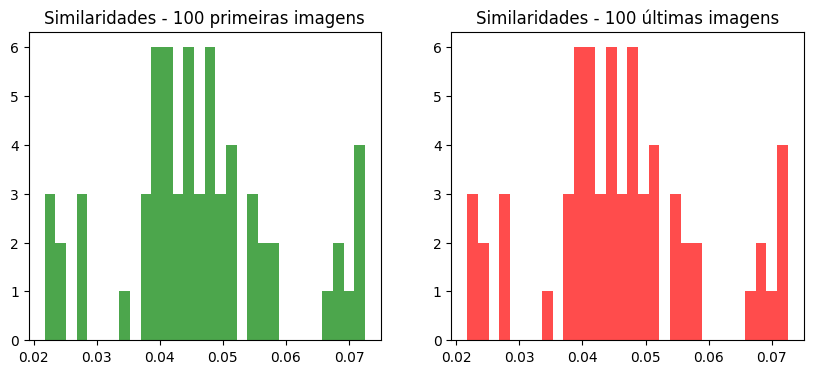

In [10]:
import matplotlib.pyplot as plt
import torch

# supondo que sims seja (num_images, num_texts)

# primeiras 100 imagens
sims_first100 = sims[:100].reshape(-1)   # pega linhas 0–99
# últimas 100 imagens
sims_last100 = sims[-100:].reshape(-1)   # pega linhas finais

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(sims_first100.cpu().numpy(), bins=30, color="green", alpha=0.7)
plt.title("Similaridades - 100 primeiras imagens")

plt.subplot(1,2,2)
plt.hist(sims_last100.cpu().numpy(), bins=30, color="red", alpha=0.7)
plt.title("Similaridades - 100 últimas imagens")

plt.show()


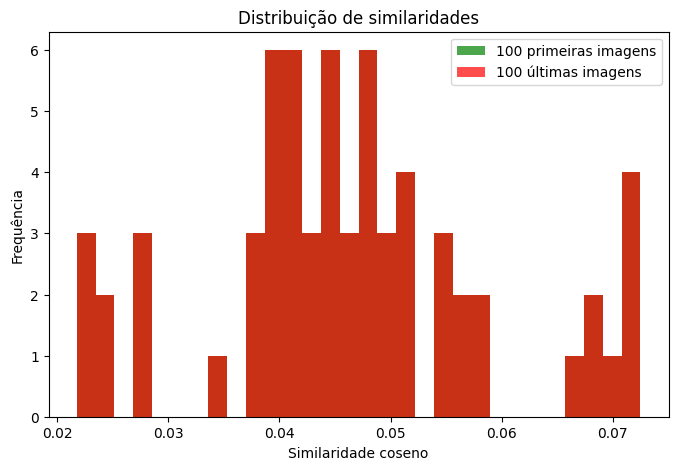

In [11]:
import matplotlib.pyplot as plt
import torch

# supondo que sims seja (num_images, num_texts)

# primeiras 100 imagens
sims_first100 = sims[:100].reshape(-1)   # linhas 0–99 achatadas
# últimas 100 imagens
sims_last100 = sims[-100:].reshape(-1)   # últimas 100 linhas achatadas

plt.figure(figsize=(8,5))

plt.hist(sims_first100.cpu().numpy(), bins=30, alpha=0.7, color="green", label="100 primeiras imagens")
plt.hist(sims_last100.cpu().numpy(), bins=30, alpha=0.7, color="red", label="100 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades")
plt.legend()
plt.show()


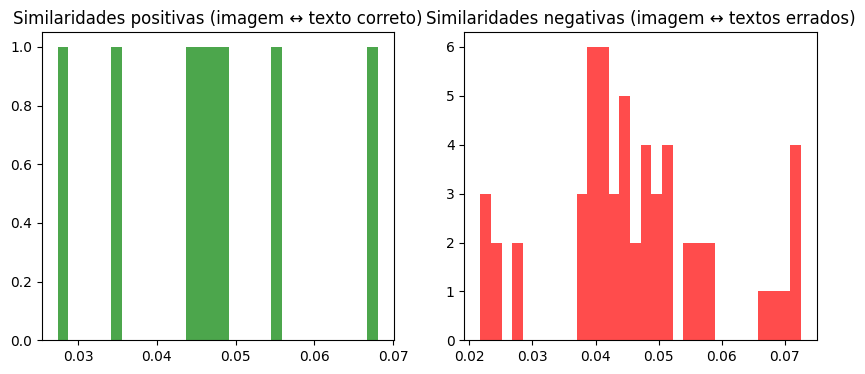

In [12]:
import matplotlib.pyplot as plt
import torch

# sims: (num_images, num_texts)

# pega a diagonal -> imagem i com texto i
positives = sims.diag().cpu().numpy()

# pega tudo fora da diagonal -> negativos
mask = ~torch.eye(sims.size(0), dtype=bool, device=sims.device)
negatives = sims[mask].cpu().numpy()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(positives, bins=30, color="green", alpha=0.7)
plt.title("Similaridades positivas (imagem ↔ texto correto)")

plt.subplot(1,2,2)
plt.hist(negatives, bins=30, color="red", alpha=0.7)
plt.title("Similaridades negativas (imagem ↔ textos errados)")

plt.show()


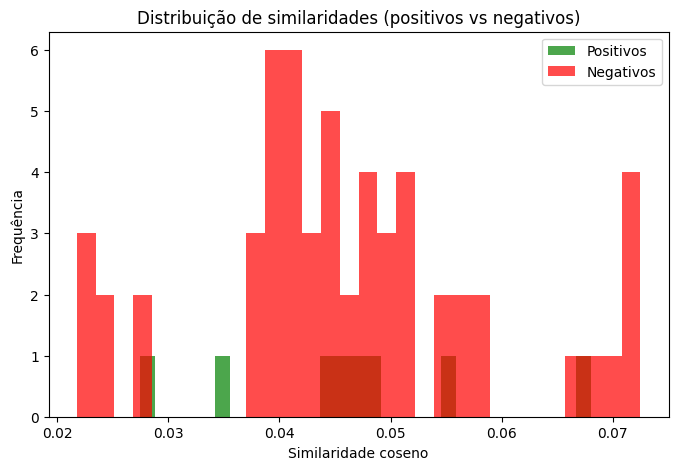

In [13]:
import matplotlib.pyplot as plt
import torch

# supondo que sims seja (num_images, num_texts)
# extraindo positivos e negativos
pos_sims = sims.diag()                          # diagonal -> imagem i com texto i
mask = ~torch.eye(sims.size(0), dtype=bool, device=sims.device)
neg_sims = sims[mask]                           # off-diagonal -> todos os pares incorretos

plt.figure(figsize=(8,5))

plt.hist(pos_sims.cpu().numpy(), bins=30, alpha=0.7, color="green", label="Positivos")
plt.hist(neg_sims.cpu().numpy(), bins=30, alpha=0.7, color="red", label="Negativos")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (positivos vs negativos)")
plt.legend()
plt.show()


In [14]:
# --- Configurações ---
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
num_epochs = 5
lr = 1e-4

ds_train, ds_valid = get_dataset("../Graphs/data/images", "../Graphs/data/edgelists.json")
# --- Otimizador ---
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# --- Loop de Treino ---
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for imgs, texts in dl:
        imgs = imgs.to(device)
        
        # Tokeniza os textos do batch
        enc_texts = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt").to(device)
        input_ids = enc_texts["input_ids"]
        
        optimizer.zero_grad()
        logits = model(imgs, list(texts))
        loss = clip_loss(logits)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss média: {total_loss/len(dl):.4f}")


Epoch 1/5, Loss média: 2.1459
Epoch 2/5, Loss média: 2.1160
Epoch 3/5, Loss média: 2.1097
Epoch 4/5, Loss média: 2.0886
Epoch 5/5, Loss média: 2.0937


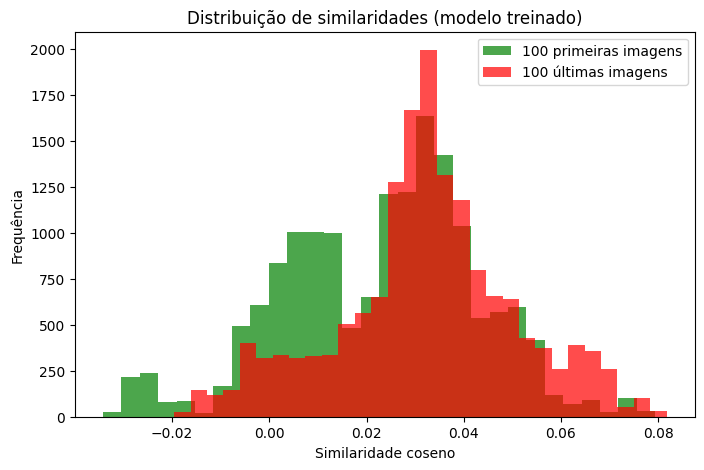

In [15]:
def compute_sims(model, dataloader, device="cpu"):
    model.eval()
    all_image_embs = []
    all_texts = []

    with torch.no_grad():
        for imgs, texts in dataloader:
            imgs = imgs.to(device)
            all_image_embs.append(model.project_images(imgs))
            all_texts.extend(texts)  # mantém lista de strings

        # concatena embeddings de todas as imagens
        image_embs = torch.cat(all_image_embs, dim=0)  # (num_images, dim)

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(image_embs, text_embs.T)  # (num_images, num_texts)

    return sims

# --- Calcula similaridades ---
sims = compute_sims(model, dl, device=device)

# --- Histograma comparando 100 primeiras vs 100 últimas imagens ---
sims_first100 = sims[:100].reshape(-1)
sims_last100 = sims[-100:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first100.cpu().numpy(), bins=30, alpha=0.7, color="green", label="100 primeiras imagens")
plt.hist(sims_last100.cpu().numpy(), bins=30, alpha=0.7, color="red", label="100 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

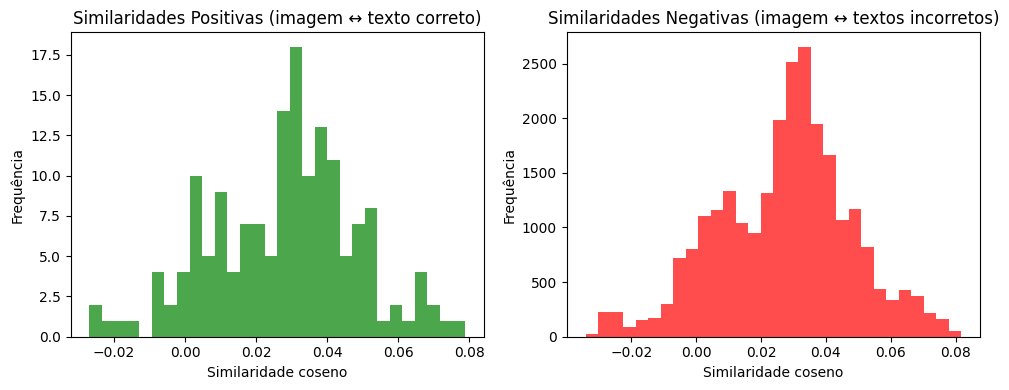

In [16]:
import matplotlib.pyplot as plt
import torch

# garantir diagonal segura
num = min(sims.size(0), sims.size(1))
pos_sims = sims[:num, :num].diagonal()
mask = ~torch.eye(num, dtype=bool, device=sims.device)
neg_sims = sims[:num, :num][mask]

plt.figure(figsize=(10,4))

# Histograma dos positivos
plt.subplot(1,2,1)
plt.hist(pos_sims.cpu().numpy(), bins=30, color="green", alpha=0.7)
plt.title("Similaridades Positivas (imagem ↔ texto correto)")
plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")

# Histograma dos negativos
plt.subplot(1,2,2)
plt.hist(neg_sims.cpu().numpy(), bins=30, color="red", alpha=0.7)
plt.title("Similaridades Negativas (imagem ↔ textos incorretos)")
plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


### Zero-shot classification

Como o modelo envolve similaridade entre texto e imagens, é difícil medir a qualidade de forma intuitiva. Uma forma de fazer isso é verificando a capacidade do modelo de ser aplicado em outras tarefas como classificação de imagens. Como o modelo não foi treinado para tal tarefa, isso é chamado de zero-shot accuracy.

Vamos implementar uma função simples de acurácia que verifica a capacidade do modelo em classificar as imagens nas classes gato e chachorro.

In [17]:
@torch.no_grad()
def zero_shot_classification(model, imgs, label_embeds):

    # Projeção das imagens
    image_embeds = model.project_images(imgs)
    # Similaridade entre cada imagem e as palavras 'cat' e 'dog'
    scores = torch.matmul(image_embeds, label_embeds.t())
    # Índice da classe mais provável
    predictions = scores.argmax(dim=1)

    return predictions

label_embeds = model.project_texts(["cat", "dog"])
predictions = zero_shot_classification(model, imgs, label_embeds)
print(predictions)

tensor([1, 1, 0, 1, 1, 1, 1, 1])


In [18]:
def accuracy(predictions, texts):
    """Mede a acurácia do modelo. Esta função estima a classe correta de cada imagem utilizando
    as respectivas legendas. O ideal seria utilizar as classes conhecidas do dataset Oxford Pets,
    mas isso adicionaria complexidade ao código."""
    
    targets = []
    for text in texts:
        if "cat" in text or "kitten" in text:
            target = 0
        elif "dog" in text or "puppy" in text:
            target = 1
        else:
            # Classe não reconhecida
            target = 2
        targets.append(target)
    targets = torch.tensor(targets, device=predictions.device)

    # Fração das imagens da classe gato (cachorro) que são mais similares à 
    # palavra 'cat' ('dog')
    mask = targets!=2
    targets = targets[mask]
    predictions = predictions[mask]
    acc = (predictions==targets).float().mean()

    return acc

accuracy(predictions, texts)

tensor(nan)